# Data Question 3: Earthquakes

## We are tasked with determining the factors that make an earthquake more likely, more deadly, and where they are most and least likely to occur.

## Data cleaning tasks include:

   1. Replace empty strings with NaN
   2. Remove the footnotes from the 'Other Source Deaths' column
   3. Convert Magnitude to a numeric
   4. Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
   5. Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).

In [48]:
import numpy as np
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup as BS
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import seaborn as sns

%matplotlib inline
# Increasing default figure size of the notebook
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 18

In [49]:
# create a Request object for the wikipedia page for the Deadly Earthquakes
response = requests.get('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')

# read the resulting HTML into a variable called result_text
result_text = response.text

In [50]:
result_text;

In [51]:
print(type(response))
print(type(result_text))

<class 'requests.models.Response'>
<class 'str'>


In [52]:
# create the soup by constructing a BS object from the html page and the appropriate parser
soup = BS(result_text, 'html.parser')

In [53]:
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of deadly earthquakes since 1900 - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_deadly_earthquakes_since_1900","wgTitle":"List of deadly earthquakes since 1900","wgCurRevisionId":863562959,"wgRevisionId":863562959,"wgArticleId":11673441,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles needing additional references from July 2017","All articles needing additional references","Articles needing cleanup from July 2017","All pages needing cleanup","Cleanup tagged articles with a reason field from July 20

In [54]:
#Find all instances of sortable tables (the one we are interested in)
table = soup.findAll('table', attrs = {'class':'sortable wikitable'})

In [55]:
table;

In [56]:
#Identify table rows by 'tr' tag
table_rows = table[0].findAll('tr')
table_rows;

In [57]:
#Create data frame
data = []
for ind, tr in enumerate(table_rows):
    tag = 'td' if ind else 'th' #assign 'td' tag to all indeces and 'th' to everything else
    row = [elem.text for elem in tr.findAll(tag)] #fill the list row with the text for each element with 'tr' tag
    data.append(row)
earthquakes_df = pd.DataFrame(data[1:], columns=data[0])
earthquakes_df.head()

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,,,,,,\n
1,1900-07-12 06:25,Turkey,40.300,43.100,,5.9 Muk,,,,140,,\n
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,,,,,,\n
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,,,,,,\n
4,1901-03-31 07:11,Bulgaria,43.400,28.700,,6.4 Muk,,,,4,,\n


### Secondary effects are reported, they are indicated by “T”, “L”, “F” or “Lq”
T = Tsunami, L = Landslide, F = Fire, Lq = Liquefaction

PDE Totals are reported by United States Geological Survey’s Preliminary Determination of Epicenters <br>

<strong>pde_shaking</strong> = Deaths from shaking only <br>

<strong>pde_total</strong> = total fatalities resulting from earthquake shaking and secondary effects, such as tsunami, landslide, fire, liquefaction or other factors (e.g., heart failure) <br>

<strong>utsu_total</strong> = the total deaths resulting from an earthquake (up to date up to 2003) <br>

<strong>em_dat_total</strong> = records from the Emergency Events Database (Earthquake source parameters in the EM-DAT are often absent, incomplete, or erroneous. Consequently, several events may be missed in the automated catalog associations. Furthermore, where the impact of an earthquake spans political boundaries, database entries are often subdivided by country. For significant events, the observed fatalities are aggregated and manually associated.) <br>

<strong>other_source</strong> = other sources of shaking deaths and indicates improved fatality estimates from official reports and detailed scholarly studies, where available

In [58]:
earthquakes_df.columns

Index(['Origin (UTC)', 'Present-day country and link to Wikipedia article',
       'Lat', 'Long', 'Depth (km)', 'Magnitude', 'Secondary Effects',
       'PDE Shaking Deaths', 'PDE Total Deaths', 'Utsu Total Deaths',
       'EM-DAT Total Deaths', 'Other Source Deaths\n'],
      dtype='object')

### First we need to clean the data, removing all but the numerical values of the cells:

In [59]:
earthquakes_df['Origin (UTC)'] = pd.to_datetime(earthquakes_df['Origin (UTC)'])
earthquakes_df['Present-day country and link to Wikipedia article'] = earthquakes_df['Present-day country and link to Wikipedia article'].replace(' \(.*?\)', '', regex=True)

In [60]:
#Remove all line escapes from the end of the table values
earthquakes_df['Other Source Deaths\n'] = earthquakes_df['Other Source Deaths\n'].replace('\\n','', regex=True)
earthquakes_df;

In [61]:
#Fill empty cells with NaN, remove "+" values
earthquakes_df = earthquakes_df.replace("", np.nan)
earthquakes_df['Other Source Deaths\n'] = earthquakes_df['Other Source Deaths\n'].str.replace('+', '')
earthquakes_df['Other Source Deaths\n'].unique()

array([nan, '3500', '8000', '46', '164[6]', '1500[6]', '105000', '1404',
       '1', '120', '200', None, '380', '2041', '33[8]', '45000[9]',
       '2489[10]', '26271[11] 26000[12]', '68',
       '231000*[13] 283000*[14] 227898*[15]', '41', '60[16]', '215', '34',
       '295', '79', '189', '1,115', '222,517[17]', '521[19]', '42',
       '2,698', '181', '15894[20]', '150', '111',
       '601 (as of October 30, 2011)'], dtype=object)

In [62]:
#Remove footnotes
earthquakes_df['Other Source Deaths\n'] = earthquakes_df['Other Source Deaths\n'].replace('\[\d+\]', '', regex=True)
earthquakes_df['Other Source Deaths\n'].unique()

array([nan, '3500', '8000', '46', '164', '1500', '105000', '1404', '1',
       '120', '200', None, '380', '2041', '33', '45000', '2489',
       '26271 26000', '68', '231000* 283000* 227898*', '41', '60', '215',
       '34', '295', '79', '189', '1,115', '222,517', '521', '42', '2,698',
       '181', '15894', '150', '111', '601 (as of October 30, 2011)'],
      dtype=object)

In [63]:
#Remove double entry
earthquakes_df['Other Source Deaths\n'] = earthquakes_df['Other Source Deaths\n'].str.replace('26271 26000', '26271')
earthquakes_df['Other Source Deaths\n'].unique()

array([nan, '3500', '8000', '46', '164', '1500', '105000', '1404', '1',
       '120', '200', None, '380', '2041', '33', '45000', '2489', '26271',
       '68', '231000* 283000* 227898*', '41', '60', '215', '34', '295',
       '79', '189', '1,115', '222,517', '521', '42', '2,698', '181',
       '15894', '150', '111', '601 (as of October 30, 2011)'],
      dtype=object)

In [64]:
#Remove astrisks and commas, average the triple entry
earthquakes_df['Other Source Deaths\n'].replace(regex=True,inplace=True,to_replace=r'\*', value='')
earthquakes_df['Other Source Deaths\n'].replace(regex=True,inplace=True,to_replace=r'\,', value='')
earthquakes_df['Other Source Deaths\n'] = earthquakes_df['Other Source Deaths\n'].str.replace('231000 283000 227898', '247299')
earthquakes_df['Other Source Deaths\n'].unique()

array([nan, '3500', '8000', '46', '164', '1500', '105000', '1404', '1',
       '120', '200', None, '380', '2041', '33', '45000', '2489', '26271',
       '68', '247299', '41', '60', '215', '34', '295', '79', '189',
       '1115', '222517', '521', '42', '2698', '181', '15894', '150',
       '111', '601 (as of October 30 2011)'], dtype=object)

In [65]:
#Remove parenthetical entry
earthquakes_df['Other Source Deaths\n'] = earthquakes_df['Other Source Deaths\n'].replace(' \(.*?\)', '', regex=True)
earthquakes_df['Other Source Deaths\n'].unique()

array([nan, '3500', '8000', '46', '164', '1500', '105000', '1404', '1',
       '120', '200', None, '380', '2041', '33', '45000', '2489', '26271',
       '68', '247299', '41', '60', '215', '34', '295', '79', '189',
       '1115', '222517', '521', '42', '2698', '181', '15894', '150',
       '111', '601'], dtype=object)

In [66]:
earthquakes_df.head(10)

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23:00,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140,NaN,NaN
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4,NaN,NaN
5,1901-08-09 09:23:00,Japan,40.500,142.500,35,7.2 Mw,T,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15:00,New Zealand,-43.000,173.000,0,6.8 Ms,NaN,NaN,NaN,1,NaN,NaN
7,1902-01-30 14:01:00,Japan,40.500,141.300,35,6.9 Ms,NaN,NaN,NaN,1,NaN,NaN
8,1902-02-13 09:39:00,Azerbaijan,40.700,48.600,15,6.9 Muk,NaN,NaN,NaN,86,NaN,NaN
9,1902-03-09 07:46:00,Turkey,40.700,33.600,NaN,5.5 Muk,NaN,NaN,NaN,4,NaN,NaN


In [67]:
#ALTERNATE METHOD TO IMPORT DATA
# dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900', header=0, index_col=0)
# len(dfs)
# earthquakes = dfs[5]

In [68]:
#Standardize Magnitude column to numeric values
earthquakes_df.Magnitude = earthquakes_df.Magnitude.str.replace('5 ML', '5.0 ML') #correction for non-decimal entry
earthquakes_df.Magnitude = earthquakes_df.Magnitude.str.extract('(\d+\.\d+)')
earthquakes_df.Magnitude = pd.to_numeric(earthquakes_df.Magnitude)
earthquakes_df

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23:00,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140,NaN,NaN
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4,NaN,NaN
5,1901-08-09 09:23:00,Japan,40.500,142.500,35,7.2,T,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15:00,New Zealand,-43.000,173.000,0,6.8,NaN,NaN,NaN,1,NaN,NaN
7,1902-01-30 14:01:00,Japan,40.500,141.300,35,6.9,NaN,NaN,NaN,1,NaN,NaN
8,1902-02-13 09:39:00,Azerbaijan,40.700,48.600,15,6.9,NaN,NaN,NaN,86,NaN,NaN
9,1902-03-09 07:46:00,Turkey,40.700,33.600,NaN,5.5,NaN,NaN,NaN,4,NaN,NaN


### Next we convert our data to numeric values so that they can be compared across the row:

In [69]:
#convert all death columns to numeric, using same standardization as above
pd.to_datetime(earthquakes_df['Origin (UTC)'])
earthquakes_df['PDE Total Deaths'] = pd.to_numeric(earthquakes_df['PDE Total Deaths'], errors='coerce');
earthquakes_df['Utsu Total Deaths'] = pd.to_numeric(earthquakes_df['Utsu Total Deaths'], errors='coerce');

earthquakes_df['EM-DAT Total Deaths'] = earthquakes_df['EM-DAT Total Deaths'].str.replace('\n', '')
earthquakes_df['EM-DAT Total Deaths'] = earthquakes_df['EM-DAT Total Deaths'].replace('\[\d+\]', '', regex=True)
earthquakes_df['EM-DAT Total Deaths'] = earthquakes_df['EM-DAT Total Deaths'].str.replace('|', '')
earthquakes_df['Lat'] = earthquakes_df['Lat'].replace('?', np.nan)
earthquakes_df['Long'] = earthquakes_df['Long'].replace('??', np.nan)
                                                       
earthquakes_df['EM-DAT Total Deaths'] = pd.to_numeric(earthquakes_df['EM-DAT Total Deaths'], errors='coerce');
earthquakes_df[ 'Other Source Deaths\n'] = pd.to_numeric(earthquakes_df[ 'Other Source Deaths\n'], errors='coerce');

In [70]:
#Eliminate NaN values in our final column
earthquakes_df['Other Source Deaths\n'] = earthquakes_df['Other Source Deaths\n'].fillna(0)
earthquakes_df['Other Source Deaths\n'].unique()

array([0.00000e+00, 3.50000e+03, 8.00000e+03, 4.60000e+01, 1.64000e+02,
       1.50000e+03, 1.05000e+05, 1.40400e+03, 1.00000e+00, 1.20000e+02,
       2.00000e+02, 3.80000e+02, 2.04100e+03, 3.30000e+01, 4.50000e+04,
       2.48900e+03, 2.62710e+04, 6.80000e+01, 2.47299e+05, 4.10000e+01,
       6.00000e+01, 2.15000e+02, 3.40000e+01, 2.95000e+02, 7.90000e+01,
       1.89000e+02, 1.11500e+03, 2.22517e+05, 5.21000e+02, 4.20000e+01,
       2.69800e+03, 1.81000e+02, 1.58940e+04, 1.50000e+02, 1.11000e+02,
       6.01000e+02])

In [71]:
earthquakes_df.head(10)

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23:00,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,0.0
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,0.0
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,0.0
3,1901-02-15 00:00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,0.0
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,0.0
5,1901-08-09 09:23:00,Japan,40.500,142.500,35,7.2,T,NaN,NaN,NaN,NaN,0.0
6,1901-11-15 20:15:00,New Zealand,-43.000,173.000,0,6.8,NaN,NaN,NaN,1.0,NaN,0.0
7,1902-01-30 14:01:00,Japan,40.500,141.300,35,6.9,NaN,NaN,NaN,1.0,NaN,0.0
8,1902-02-13 09:39:00,Azerbaijan,40.700,48.600,15,6.9,NaN,NaN,NaN,86.0,NaN,0.0
9,1902-03-09 07:46:00,Turkey,40.700,33.600,NaN,5.5,NaN,NaN,NaN,4.0,NaN,0.0


### Now that the data has been cleaned, we need a new column with the maximum row value for death counts:

In [72]:
# Create a 'deaths' column containing the maximum value for all the previous death columns per row
earthquakes_df['deaths'] = earthquakes_df[['PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', \
                                           'Other Source Deaths\n']].max(axis=1)
earthquakes_df

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,deaths
0,1900-05-11 17:23:00,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,0.0,140.0
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1901-02-15 00:00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,0.0,4.0
5,1901-08-09 09:23:00,Japan,40.500,142.500,35,7.2,T,NaN,NaN,NaN,NaN,0.0,0.0
6,1901-11-15 20:15:00,New Zealand,-43.000,173.000,0,6.8,NaN,NaN,NaN,1.0,NaN,0.0,1.0
7,1902-01-30 14:01:00,Japan,40.500,141.300,35,6.9,NaN,NaN,NaN,1.0,NaN,0.0,1.0
8,1902-02-13 09:39:00,Azerbaijan,40.700,48.600,15,6.9,NaN,NaN,NaN,86.0,NaN,0.0,86.0
9,1902-03-09 07:46:00,Turkey,40.700,33.600,NaN,5.5,NaN,NaN,NaN,4.0,NaN,0.0,4.0


### Now we start to plot our data, beginning with the simplest representation:

In [73]:
#Subset the data for information needed to plot to a map
earthquakes_coords = earthquakes_df[['Origin (UTC)', 'Present-day country and link to Wikipedia article', 'Lat', \
                                     'Long', 'Magnitude', 'deaths']]
#Latitudes and longitudes must be numeric to plot
earthquakes_coords.Lat = pd.to_numeric(earthquakes_coords.Lat, errors='coerce')
earthquakes_coords.Long = pd.to_numeric(earthquakes_coords.Long, errors='coerce')
earthquakes_coords = earthquakes_coords.dropna()
earthquakes_coords.info() #Making sure that there are no more missing latitudes or longitudes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1324 entries, 0 to 1339
Data columns (total 6 columns):
Origin (UTC)                                         1324 non-null datetime64[ns]
Present-day country and link to Wikipedia article    1324 non-null object
Lat                                                  1324 non-null float64
Long                                                 1324 non-null float64
Magnitude                                            1324 non-null float64
deaths                                               1324 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 72.4+ KB


/Users/andrewmarsee/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [74]:
# #Plot  all location data, adjusting the radius of each point based on magnitude (a logarithmic scaled measurement)
# from mpl_toolkits.basemap import Basemap
# plt.figure(figsize=(14, 8))
# earth = Basemap()
# earth.bluemarble(alpha=0.42)
# earth.drawcoastlines(color='#555566', linewidth=1)
# plt.scatter(earthquakes_coords.Long, earthquakes_coords.Lat, c='red',alpha=0.25, s=2.25**(earthquakes_df.Magnitude));
# #Here we have chosen to indicate Magnitude (based on Richter scaling) by the radius of each point

### This already gives a pretty good indication of earthquake location and severity.

### Lets get a little more detailed and make things more legible:

In [75]:
map_heat = folium.Map(location = [0,0], zoom_start = 2) 
#draw our plate boundaries: plate_bounds
plate_bounds = gpd.read_file('./tectonic_boundaries.geojson')
folium.GeoJson(plate_bounds).add_to(map_heat)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = earthquakes_coords[['Lat', 'Long']]
# Not necessary to remove NaNs because that was done earlier in the notebook
# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Long']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_heat)

# Display the map
map_heat

### Now we can zoom in and see things a little more clearly, and all on top of a map of tectonic plate lines! 

### But we want to see a bit more detail, including magnitudes and the locations of larger death totals:

In [76]:
#create our map of the world and show it
map_world = folium.Map(location = [0,0], zoom_start = 2, tiles='Mapbox Control Room')

#draw our plate boundaries: plate_bounds
plate_bounds = gpd.read_file('./tectonic_boundaries.geojson')
folium.GeoJson(plate_bounds).add_to(map_world)

#Plot our data focusing on magnitude and death toll
for row in earthquakes_coords.iterrows():
   row_values = row[1]
   location = [row_values['Lat'], row_values['Long']]
   popup = 'Date: ' + str(row_values['Origin (UTC)']) + '<br/>' +  'Country: ' + str(row_values[ \
                  'Present-day country and link to Wikipedia article']) + '<br/>' + 'Magnitude: ' + str(row_values[ \
                  'Magnitude'])+ '<br/>'+ 'Deaths: ' + str(row_values['deaths'])
   mag_radius = 4.5 ** row_values['Magnitude']
   #mag_radius = row_values['magnitude'] ** 6.2
   death_radius = row_values['deaths']  * 5
#    marker = folium.Marker(location = location)
#    marker.add_to(map_world)
   if row_values['Magnitude'] < 5.5:
       marker = folium.Circle(location=location, radius=death_radius, color='blue', fill=False, fill_color='blue').add_to(map_world)
       marker.add_to(map_world)   
   elif 5.5 <= row_values['Magnitude'] < 8:
       marker = folium.Circle(location=location, radius=death_radius, color='green', fill=False, fill_color='green').add_to(map_world)
       marker.add_to(map_world)
   elif row_values['Magnitude'] >= 8:
       marker = folium.Circle(popup=popup, location=location, radius=death_radius, color='crimson', fill=False, fill_color='crimson').add_to(map_world)
       marker.add_to(map_world)

   if row_values['deaths'] >= 10000:
       marker = folium.Circle(popup=popup, location=location, radius=mag_radius, color='red', fill=False, fill_color='red').add_to(map_world)
       marker.add_to(map_world)

# Show map
map_world

## Now we have a solid grasp of location data, but this is still shows only part of the picture.

### We would also like to compare the frequencies and densities of each country's earthquake data

/Users/andrewmarsee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


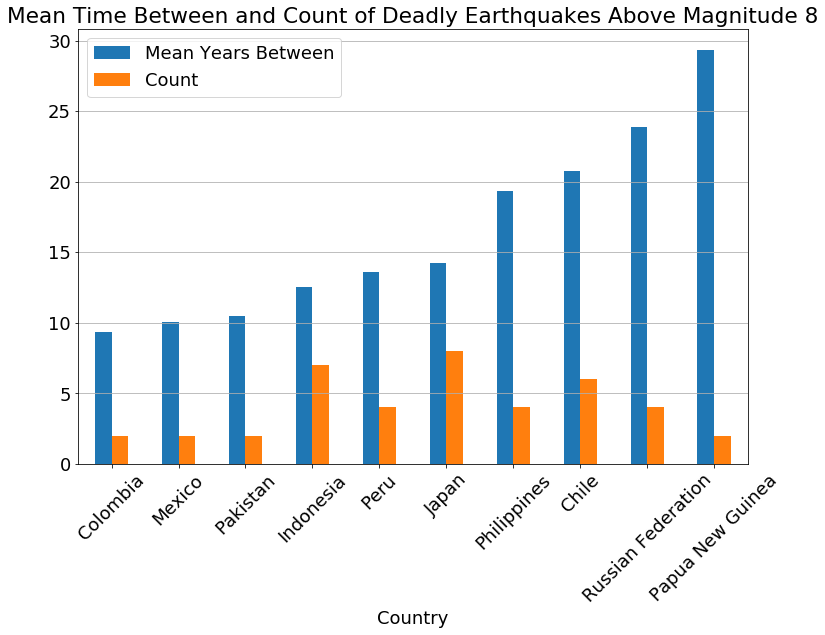

In [101]:
between_8_9 = earthquakes_df.loc[earthquakes_df['Magnitude']>=8]
#between_8_9 = between_8_9.loc[between_8_9['magnitude']<9]
between_8_9.shape;

# Aggregate by count and average time difference
time_diff_8_9 = between_8_9.groupby('Present-day country and link to Wikipedia article')['Origin (UTC)'].agg({'count': 'count', \
                                    'avg_time_diff': lambda x: x.sort_values().diff().mean()})
time_diff_8_9 = time_diff_8_9.reset_index()

time_diff_8_9['years'] = (time_diff_8_9.avg_time_diff.dt.days / 365).round(2)

time_diff_8_9.sort_values(by='years', ascending=True).head(10).plot(kind='bar', y=['years','count'], \
                                    x='Present-day country and link to Wikipedia article', legend=True)
plt.grid(axis='y')
plt.legend(['Mean Years Between', 'Count'])
plt.title('Mean Time Between and Count of Deadly Earthquakes Above Magnitude 8')
plt.xlabel('Country')
#plt.ylabel('Mean Time Between Earthquakes (Years)')
plt.xticks(rotation=45);

### Colombia had the shortest amount of time on average between great earthquakes, but they only had two of them. They were unfortunate that they happened relatively close together

### We have to go to Peru to find a little bit better sample size. They had 4 such earthquakes and they occurred roughly every 14 years

/Users/andrewmarsee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


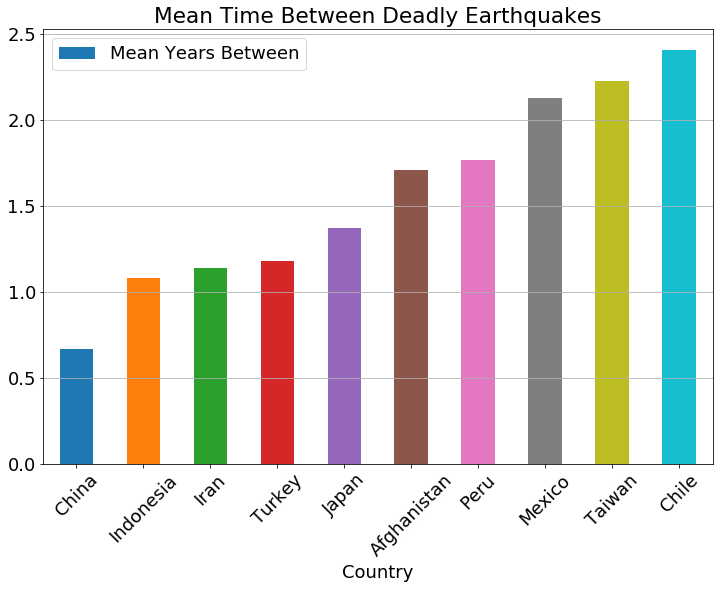

In [106]:
all_eqs = earthquakes_df
#between_8_9 = between_8_9.loc[between_8_9['magnitude']<9]
between_8_9.shape;

# Aggregate by count and average time difference
time_diff = all_eqs.groupby('Present-day country and link to Wikipedia article')['Origin (UTC)'].agg({'count': 'count', \
                                    'avg_time_diff': lambda x: x.sort_values().diff().mean()})
time_diff = time_diff.reset_index()

time_diff['years'] = (time_diff.avg_time_diff.dt.days / 365).round(2)

time_diff.sort_values(by='years', ascending=True).iloc[2:12,:].plot(kind='bar', y='years', \
                                    x='Present-day country and link to Wikipedia article', legend=True)
plt.grid(axis='y')
plt.legend(['Mean Years Between', 'Count'])
plt.title('Mean Time Between Deadly Earthquakes')
plt.xlabel('Country')
#plt.ylabel('Mean Time Between Earthquakes (Years)')
plt.xticks(rotation=45);

### We would also like to take into account the country's size. It is natural for a larger country to be affected by more earthquakes since their size makes them more likely to be hit. Therefore we have gone on to calculate "earthquake density," the amount of deadly earthquakes each county experiences per decade per 1M sq mi.

In [78]:
country_area_df = pd.read_csv('area_sq_km.csv')
country_area_df = country_area_df.iloc[:,[0,-2]]
country_area_df.columns = ['country', 'area']
country_area_df.iloc[252, 0]= 'Venezuela'
country_area_df.iloc[110, 0]= 'Iran'
country_area_df.iloc[120, 0]= 'Kyrgyzstan'
country_area_df.head()

,country,area
0,Aruba,180.0
1,Afghanistan,652860.0
2,Angola,1246700.0
3,Albania,27400.0
4,Andorra,470.0


In [79]:
# Grouping by country and counting to see the countries which have the most earthquakes
eq_count = earthquakes_df[['Present-day country and link to Wikipedia article', 'Origin (UTC)']].groupby(by = 'Present-day country and link to Wikipedia article').agg('count').sort_values(by ='Origin (UTC)', ascending = False)
eq_count = eq_count.reset_index()
eq_count.columns = ['country', 'count']
eq_count.head(10)

,country,count
0,China,166
1,Indonesia,96
2,Turkey,95
3,Iran,91
4,Japan,82
5,Peru,54
6,Taiwan,47
7,Mexico,46
8,Chile,44
9,Greece,44


In [80]:
merged_df = eq_count.merge(country_area_df, how='left', on='country')
# Adding in missing data
merged_df.iloc[6,2] = 36197 # Taiwan
merged_df.iloc[24,2] = 676578 # Burma (Myanmar)
merged_df.iloc[36,2] = 2345409 # Democratic Republic of the Congo
merged_df.head(10)

,country,count,area
0,China,166,9388211.0
1,Indonesia,96,1811570.0
2,Turkey,95,769630.0
3,Iran,91,1628760.0
4,Japan,82,364560.0
5,Peru,54,1280000.0
6,Taiwan,47,36197.0
7,Mexico,46,1943950.0
8,Chile,44,743532.0
9,Greece,44,128900.0


In [81]:
total_years = 111
decades = total_years / 10
area_unit = 1000000 # Earthquakes per 1,000,000 sq km
standard_df = merged_df
standard_df['earthquake_density'] = standard_df['count'] / total_years / (standard_df['area'] / area_unit)
standard_df.sort_values(by='earthquake_density', ascending=False).head(10)

#Number of earthquakes per year per 1,000,000 sq km (about the size of Ethiopia, a little bigger than Texas)
# or number of earthquakes per decade per 100,000 sq km (About the size of Kentucky)

,country,count,area,earthquake_density
6,Taiwan,47,36197.0,11.697749
78,Samoa,1,2830.0,3.183395
9,Greece,44,128900.0,3.075224
32,El Salvador,7,20720.0,3.043584
57,Cyprus,3,9240.0,2.925003
33,Albania,7,27400.0,2.301572
4,Japan,82,364560.0,2.026385
26,Costa Rica,10,51060.0,1.764397
58,Jamaica,2,10830.0,1.663714
65,Vanuatu,2,12190.0,1.478098


### Taiwan is by far the most heavily affected country for earthquakes based on its size. Looking at the safest countries by size:

In [82]:
standard_df.sort_values(by='earthquake_density', ascending=True).head(10)
# Least earthquake dense countries

,country,count,area,earthquake_density
86,Brazil,1,8358140.0,0.001078
56,Canada,3,9093510.0,0.002972
52,Australia,3,7682300.0,0.003518
76,Sudan,1,2376000.0,0.003792
106,Mongolia,1,1553560.0,0.005799
22,Russian Federation,13,16376870.0,0.007151
108,Mozambique,1,786380.0,0.011456
47,Kazakhstan,4,2699700.0,0.013348
73,Spain,1,500210.0,0.018010
66,Ethiopia,2,1000000.0,0.018018


### Now let's take a look at the countries with the highest total death counts:

In [83]:
Death_country=earthquakes_df.loc[:,['Present-day country and link to Wikipedia article','Origin (UTC)','deaths']]
death_aggregate=Death_country.groupby('Present-day country and link to Wikipedia article').sum()
highest_death=death_aggregate.nlargest(20,'deaths')
highest_death=highest_death.reset_index()
highest_death.head()

,Present-day country and link to Wikipedia article,deaths
0,China,1284382.0
1,Indonesia,343574.0
2,Haiti,222523.0
3,Japan,185148.0
4,Iran,177947.0


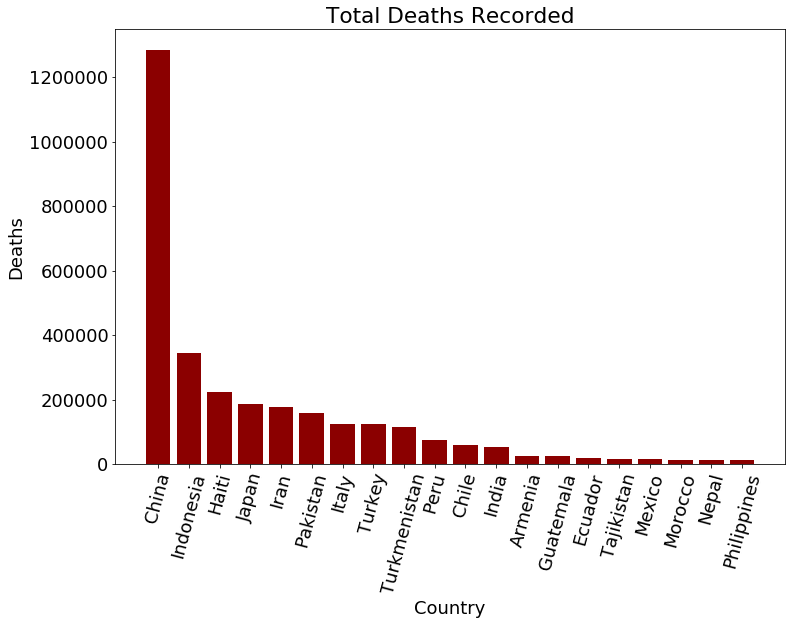

In [84]:
plt.bar(x=highest_death['Present-day country and link to Wikipedia article'], height=highest_death.deaths, width=0.8,color='darkred');
plt.xticks(rotation=75);
plt.xlabel('Country');
plt.ylabel('Deaths');
plt.title('Total Deaths Recorded');

### China is by far the leader, but in terms of population percentage it skews the perception. One of the incidents in China totaled over 650,000 deaths, but this accounted for less than a tenth of a percent of their population. By comparison, the Armenian earthquake in 1988 claimed 0.713% of their population.

### Now we will take a look at the amount of secondary effects each country has experienced:

In [85]:
earthquakes_df['Secondary Effects']=earthquakes_df['Secondary Effects'].str.replace('T,LF','T,L,F')
earthquakes_df=earthquakes_df.join(earthquakes_df['Secondary Effects'].str.get_dummies(sep=','))
earthquakes_df.head()

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,deaths,F,L,Lq,T
0,1900-05-11 17:23:00,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,0.0,140.0,0,0,0,0
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0
3,1901-02-15 00:00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,0.0,4.0,0,0,0,0


In [86]:
# select only earthquakes with either of the secondary effects reported
Sec_effects=earthquakes_df.loc[
    (earthquakes_df.F==1)|(earthquakes_df.L==1)|(earthquakes_df.Lq==1)|(earthquakes_df['T']==1),
]

In [87]:
earthquakes_dummy=Sec_effects.loc[:,['Present-day country and link to Wikipedia article','deaths','F','L','Lq','T']]

In [88]:
earthquakes_dummy=earthquakes_dummy.groupby('Present-day country and link to Wikipedia article').sum().sort_values('deaths',ascending=False)
earthquakes_dummy.head(10)

,deaths,F,L,Lq,T
Present-day country and link to Wikipedia article,,,,,
Indonesia,327806.0,2,15,1,31
Japan,184292.0,11,13,1,33
China,95287.0,1,12,0,0
Pakistan,91722.0,0,7,1,1
Italy,84539.0,0,3,0,2
Iran,77751.0,0,13,0,0
Peru,71303.0,0,9,0,10
Chile,28104.0,0,8,1,19
Guatemala,23035.0,0,4,0,1


In [89]:
earthquakes_dummy=earthquakes_dummy.reset_index()
earthquakes_Pair=earthquakes_dummy.set_index('Present-day country and link to Wikipedia article').nlargest(15,'T')
earthquakes_Pair=earthquakes_Pair.drop(['deaths'],axis=1)
earthquakes_Pair

,F,L,Lq,T
Present-day country and link to Wikipedia article,,,,
Japan,11,13,1,33
Indonesia,2,15,1,31
Chile,0,8,1,19
Mexico,0,7,0,17
Peru,0,9,0,10
Philippines,0,6,3,10
Papua New Guinea,0,9,1,7
Russian Federation,0,2,0,7
Greece,0,1,0,5


- Tsunami incident was highest in Japan followed by Indonesia, then Chile and Mexico.

- Landslides were most common in Indonesia, followed by Taiwan and then Japan.

- USA has all four incidents, but landslide was more frequent compared to other indicents. Liquefaction was the highest in USA compared with other countries.

- The data is sorted by amount of tsunami incidents, therefore China has been left out. It is a noteworthy exclusion, as China reported 12 incidents of landslides and 1 incident of fire.

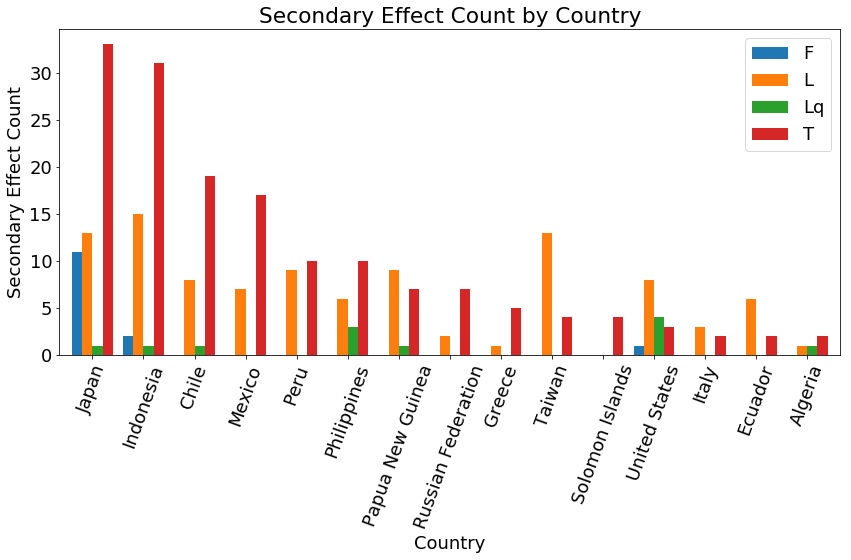

In [90]:
earthquakes_Pair.plot(kind='bar',width=0.8,figsize=(14,6));
plt.xticks(rotation=70);
plt.title('Secondary Effect Count by Country');
plt.xlabel('Country');
plt.ylabel('Secondary Effect Count');

### We also see a positive correlation in most of the secondary effects with increased death counts, most clearly with events involving landslides:

In [91]:
earthquakes_dummy=earthquakes_dummy.reset_index()

In [92]:
earthquakes_dummy=earthquakes_dummy.loc[:,['Present-day country and link to Wikipedia article','deaths','F','L','Lq','T']]
earthquakes_dummy=earthquakes_dummy.set_index('Present-day country and link to Wikipedia article')

Text(0.5,0,'number of landslides')

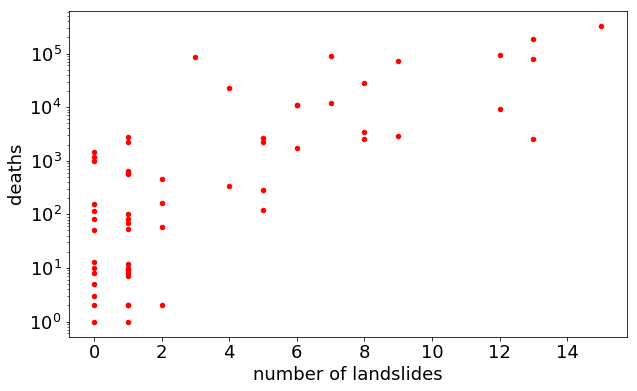

In [93]:
# association between Landslides and total number of deaths
earthquakes_dummy.plot(kind='scatter',x='L',y='deaths',color='red',logy=True,figsize=(10,6))
plt.xlabel('number of landslides')

- the association between Tsunami and deaths is less stronger than Landslides involved earthquakes

Text(0.5,0,'Tsunami')

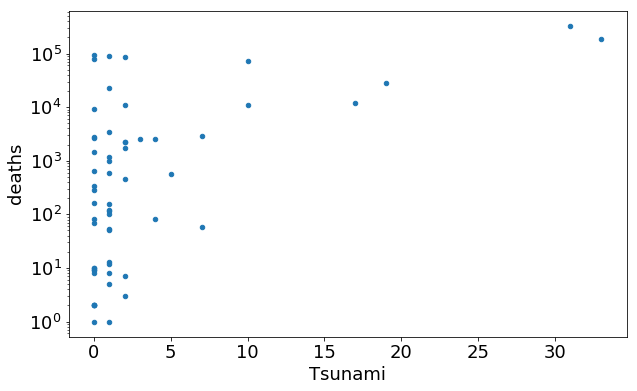

In [94]:
# association between Tsunami and total number of deaths
earthquakes_dummy.plot(kind='scatter',x='T',y='deaths',logy=True,figsize=(10,6))
plt.xlabel('Tsunami')

## Are there factors that make an earthquake more likely?

### We found that proximity to fault lines, especially where multiple tectonic plates meet, makes deadly earthquakes much more frequent.

## Are there factors that make an earthquake more deadly?

### Areas with high population density, or areas with contributing factors that make peripheral death sources more likely (mountains or loose soil suceptible to landslides, areas close to large bodies of water that can experience tsunamis, and cities with weaker infrastructures which can lead to extended fires or building collapses).

## Where would you live if you wanted to eliminate the risk of experiencing an earthquake?

### Earthquakes are almost non existent and far less deadly near the centers of tectonic plates, especially in landlocked areas. Our suggestions would be the Eastern and Midwest United States and Canada, Scandanavia, Russia, and Australia

## Where would you avoid living?

### Areas atop of major fault lines (costal areas of the Pacific Ocean and Mediterranean Sea), mountainous areas of Asia, South America and Africa, and the Mesopotamian region.